In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial
from scipy.spatial.distance import pdist, cdist, squareform ,cosine

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    transcriptor, rev_comp, lbl2lbl_id, lbl_id2lbl, collapse_mutspec
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, _prepare_nice_labels, plot_mutspec96
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

from utils import calc_mutspec_class, sbs2effect, effect2sbs, collapse_sbs192, complete_sbs_columns

sns.set_style()

In [2]:
possible_sbs6 = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]
possible_sbs96 = [x for x in possible_sbs192 if x[2:5] in possible_sbs6]
print(possible_sbs96)

['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T', 'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T', 'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T', 'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T', 'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T', 'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T', 'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T', 'G[T>G]A', 'G[T>G]C', 'G[T>G]G'

## Load and prepare data

In [98]:
# species_spectra = pd.read_csv('../data/legacy/MutSpecVertebratescytb.csv')
species_spectra = pd.read_csv('../data/new_dataset/MutSpecVertebrates192.csv.gz')
species_spectra = species_spectra[species_spectra.Gene == 'Cytb']
species_spectra['Mut'] = species_spectra['Mut'].apply(rev_comp)
cosmic = pd.read_table('../data/external/COSMIC_v3.3.1_SBS_GRCh37.txt', index_col=0)
print(species_spectra.shape)
species_spectra.head()

(325824, 7)


,Gene,Class,Species,Mut,Observed,Expected,MutSpec
39552,Cytb,Mammalia,Tarsius_dentatus,T[T>G]T,NaN,0.00,0.0
39553,Cytb,Mammalia,Tarsius_dentatus,G[T>G]T,NaN,0.00,0.0
39554,Cytb,Mammalia,Tarsius_dentatus,C[T>G]T,NaN,0.00,0.0
39555,Cytb,Mammalia,Tarsius_dentatus,A[T>G]T,NaN,0.00,0.0
39556,Cytb,Mammalia,Tarsius_dentatus,T[T>G]G,NaN,11.95,0.0


Drop SBS without transitions

In [99]:
transitions_sbs = ['C>T', 'A>G', 'G>A', 'T>C'] 
transversions_sbs = [x for x in possible_sbs12 if x not in transitions_sbs]

cutoff_ts_share = 0.25
x = cosmic.loc[cosmic.index.str.slice(2,5).isin(transitions_sbs)].sum() 
used_sbs =  x[x > cutoff_ts_share].index.values
cosmic_filtered = cosmic[used_sbs]

#Reformat cosmic table
cosmic_filtered = cosmic_filtered.T[possible_sbs96]

cosmic_filtered.head().round(4)

Type,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
SBS1,0.0009,0.0023,0.0002,0.0013,0.0003,0.0018,0.0001,0.0000,0.0016,0.0003,...,0.0001,0.0002,0.0000,0.0000,0.0003,0.0000,0.0000,0.0001,0.0006,0.0000
SBS2,0.0000,0.0001,0.0001,0.0001,0.0002,0.0001,0.0000,0.0004,0.0001,0.0000,...,0.0001,0.0002,0.0002,0.0001,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000
SBS3,0.0208,0.0165,0.0018,0.0122,0.0225,0.0253,0.0025,0.0154,0.0071,0.0109,...,0.0107,0.0070,0.0044,0.0023,0.0109,0.0058,0.0073,0.0063,0.0081,0.0105
SBS5,0.0120,0.0094,0.0018,0.0066,0.0074,0.0061,0.0035,0.0065,0.0102,0.0076,...,0.0061,0.0073,0.0025,0.0017,0.0053,0.0023,0.0052,0.0066,0.0069,0.0135
SBS6,0.0004,0.0005,0.0001,0.0002,0.0018,0.0041,0.0017,0.0096,0.0004,0.0009,...,0.0009,0.0013,0.0000,0.0002,0.0003,0.0008,0.0001,0.0003,0.0003,0.0010


In [100]:
# # Filter out species without nice spectrum: at least 16 mtypes and 40 observed mutations

# gr1 = species_spectra[~(species_spectra.MutSpec <= 0)].groupby("Species").Mut.count()
# gr2 = species_spectra.groupby("Species").Observed.sum()
# assert (gr1.index == gr2.index).all()
# used_species = gr1[(gr1 > 16) & (gr2 > 40)].index.values
# print(len(used_species))

species_spectra.Species.nunique()

1697

In [101]:
cls_spectra = calc_mutspec_class(species_spectra)
for d in [cls_spectra, species_spectra]:
    d["sbs192h"] = d.Mut
    d["sbs12h"]  = d["sbs192h"].str.slice(2, 5)
    # d["sbs192l"] = d["sbs192h"].apply(rev_comp)
    # d["sbs12l"]  = d["sbs12h"].str.translate(transcriptor)
cls_spectra

,Class,Mut,MutSpec,sbs192h,sbs12h
0,Actinopteri,A[A>C]A,0.000066,A[A>C]A,A>C
1,Actinopteri,A[A>C]C,0.001479,A[A>C]C,A>C
2,Actinopteri,A[A>C]G,0.000500,A[A>C]G,A>C
3,Actinopteri,A[A>C]T,0.000000,A[A>C]T,A>C
4,Actinopteri,A[A>G]A,0.006480,A[A>G]A,A>G
...,...,...,...,...,...
955,Mammalia,T[T>C]T,0.003399,T[T>C]T,T>C
956,Mammalia,T[T>G]A,0.000375,T[T>G]A,T>G
957,Mammalia,T[T>G]C,0.000394,T[T>G]C,T>G
958,Mammalia,T[T>G]G,0.000538,T[T>G]G,T>G


In [102]:
cls_spectra.groupby('Class').MutSpec.sum()

Class
Actinopteri     1.0
Amphibia        1.0
Aves            1.0
Lepidosauria    1.0
Mammalia        1.0
Name: MutSpec, dtype: float64

In [103]:
# mean num of mutations in single species from each class
species_spectra.groupby(["Class", "Species"]).Observed.sum().mean(level=0)

Class
Actinopteri     68.340441
Amphibia        80.584236
Aves            46.484763
Lepidosauria    77.603796
Mammalia        71.746592
Name: Observed, dtype: float64

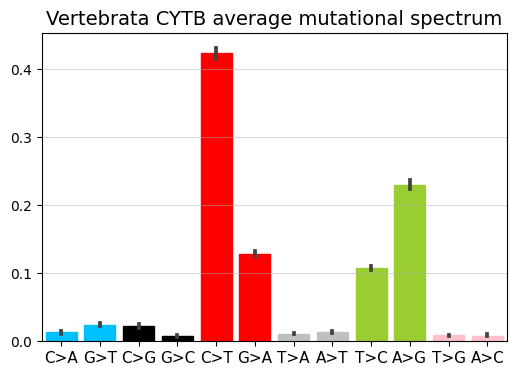

In [88]:
_species_spectra12 = species_spectra.copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata CYTB average mutational spectrum")

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


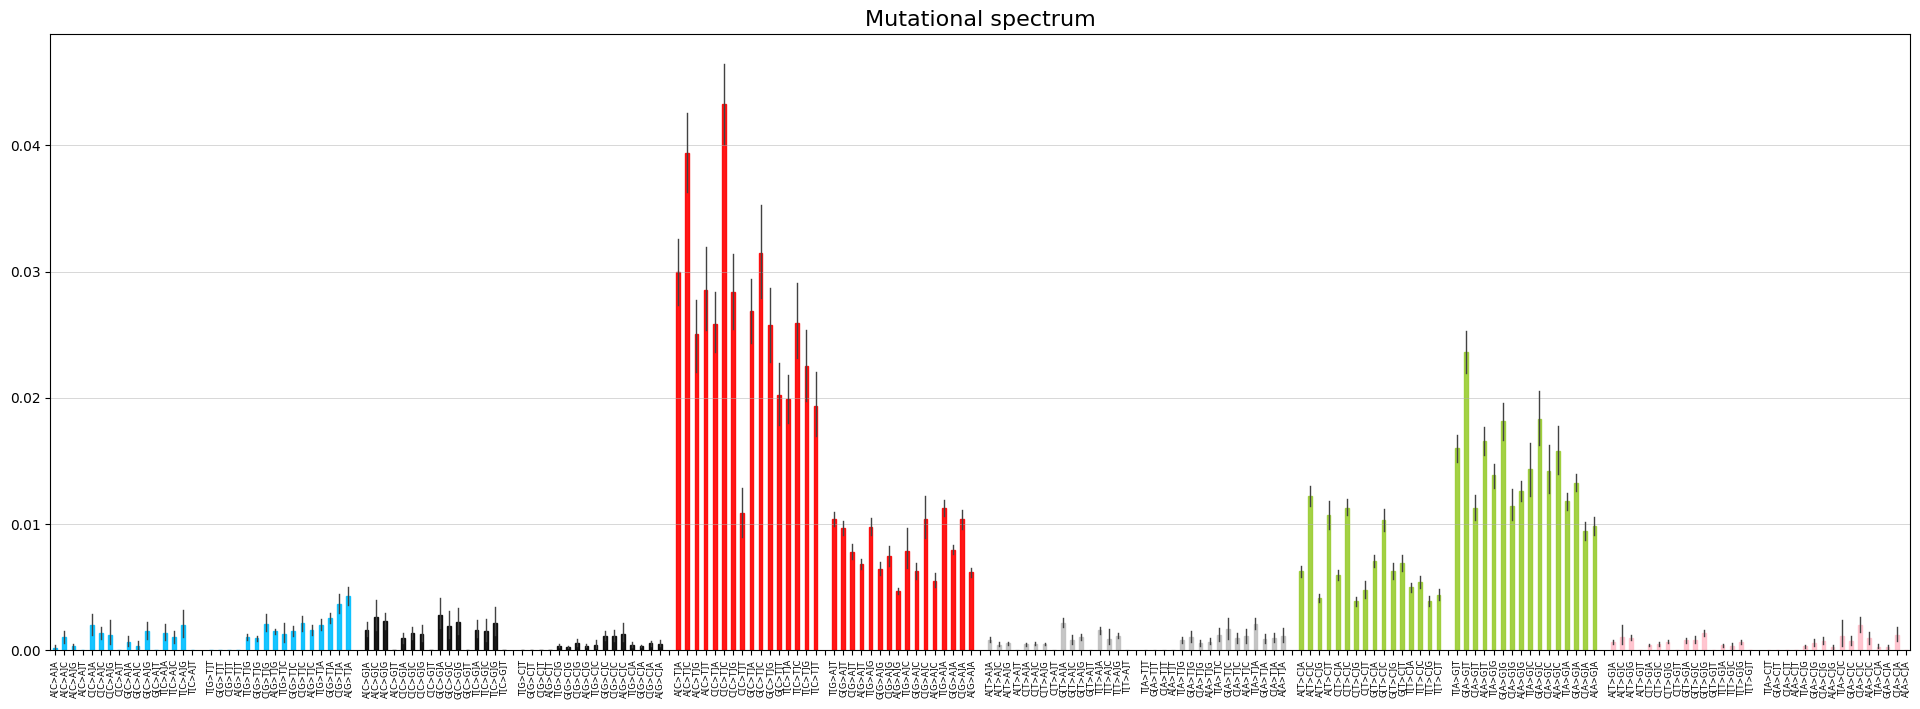

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [89]:
plot_mutspec192(species_spectra)

## Direct compare with signatures by CosSim
species-wise & cls-wise

transversions are NA

### Prepare species dataset

1. only transitions on light 
2. only C>T (light)
3. only A>G (light)

In [104]:
species_ct_raw = species_spectra[species_spectra.sbs12h == "G>A"]
species_ct_raw['sbs96'] = species_ct_raw.sbs192h.apply(rev_comp)

species_ag_raw = species_spectra[species_spectra.sbs12h == "T>C"]
species_ag_raw['sbs96'] = species_ag_raw.sbs192h

species_transitions_raw = pd.concat([species_ct_raw, species_ag_raw], ignore_index=True)

species_ct = complete_sbs_columns(
    species_ct_raw.groupby(["Class", "Species", "sbs96"]).MutSpec.sum().unstack(), 96)
species_ag = complete_sbs_columns(
    species_ag_raw.groupby(["Class", "Species", "sbs96"]).MutSpec.sum().unstack(), 96)
species_transitions = complete_sbs_columns(
    species_transitions_raw.groupby(["Class", "Species", "sbs96"]).MutSpec.sum().unstack(), 96)

assert (species_transitions.columns.values == cosmic_filtered.columns.values).all()
assert (species_ct.columns.values == cosmic_filtered.columns.values).all()
assert (species_ag.columns.values == cosmic_filtered.columns.values).all()

species_transitions.head(5).round(4)

sbs96                                     A[C>A]A  A[C>A]C  A[C>A]G  A[C>A]T  \
Class       Species                                                            
Actinopteri Abbottina_rivularis               0.0      0.0      0.0      0.0   
            Acanthopagrus_latus               0.0      0.0      0.0      0.0   
            Acanthopagrus_taiwanensis         0.0      0.0      0.0      0.0   
            Acentrogobius_janthinopterus      0.0      0.0      0.0      0.0   
            Acheilognathus_barbatulus         0.0      0.0      0.0      0.0   

sbs96                                     C[C>A]A  C[C>A]C  C[C>A]G  C[C>A]T  \
Class       Species                                                            
Actinopteri Abbottina_rivularis               0.0      0.0      0.0      0.0   
            Acanthopagrus_latus               0.0      0.0      0.0      0.0   
            Acanthopagrus_taiwanensis         0.0      0.0      0.0      0.0   
            Acentrogobius_janthinopterus      0.0      0.0      0.0      0.0   
            Acheilognathus_barbatulus         0.0      0.0      0.0      0.0   

sbs96                                     G[C>A]A  G[C>A]C  ...  C[T>G]G  \
Class       Species                                         ...            
Actinopteri Abbottina_rivularis               0.0      0.0  ...      0.0   
            Acanthopagrus_latus               0.0      0.0  ...      0.0   
            Acanthopagrus_taiwanensis         0.0      0.0  ...      0.0   
            Acentrogobius_janthinopterus      0.0      0.0  ...      0.0   
            Acheilognathus_barbatulus         0.0      0.0  ...      0.0   

sbs96                                     C[T>G]T  G[T>G]A  G[T>G]C  G[T>G]G  \
Class       Species                                                            
Actinopteri Abbottina_rivularis               0.0      0.0      0.0      0.0   
            Acanthopagrus_latus               0.0      0.0      0.0      0.0   
            Acanthopagrus_taiwanensis         0.0      0.0      0.0      0.0   
            Acentrogobius_janthinopterus      0.0      0.0      0.0      0.0   
            Acheilognathus_barbatulus         0.0      0.0      0.0      0.0   

sbs96                                     G[T>G]T  T[T>G]A  T[T>G]C  T[T>G]G  \
Class       Species                                                            
Actinopteri Abbottina_rivularis               0.0      0.0      0.0      0.0   
            Acanthopagrus_latus               0.0      0.0      0.0      0.0   
            Acanthopagrus_taiwanensis         0.0      0.0      0.0      0.0   
            Acentrogobius_janthinopterus      0.0      0.0      0.0      0.0   
            Acheilognathus_barbatulus         0.0      0.0      0.0      0.0   

sbs96                                     T[T>G]T  
Class       Species                                
Actinopteri Abbottina_rivularis               0.0  
            Acanthopagrus_latus               0.0  
            Acanthopagrus_taiwanensis         0.0  
            Acentrogobius_janthinopterus      0.0  
            Acheilognathus_barbatulus         0.0  

[5 rows x 96 columns]

### Compare transitions<sub>L</sub> with COSMIC

In [105]:
# the table contain similarity of secies (index) versus signature (column)
sim = pd.DataFrame(1 - cdist(species_transitions, cosmic_filtered, "cosine"), index=species_transitions.index, columns=cosmic_filtered.index)
sim

SBS1      SBS2      SBS3  \
Class       Species                                                      
Actinopteri Abbottina_rivularis           0.125252  0.030758  0.324212   
            Acanthopagrus_latus           0.545380  0.223296  0.315227   
            Acanthopagrus_taiwanensis     0.089973  0.103254  0.236290   
            Acentrogobius_janthinopterus  0.150987  0.169106  0.315800   
            Acheilognathus_barbatulus     0.173449  0.151077  0.227081   
...                                            ...       ...       ...   
Mammalia    Xerus_inauris                 0.452590  0.061646  0.283648   
            Zapus_hudsonius               0.415295  0.254678  0.299129   
            Zapus_princeps                0.276060  0.244217  0.439071   
            Zapus_trinotatus              0.184009  0.409143  0.315201   
            Ziphius_cavirostris           0.614836  0.186543  0.263125   

                                              SBS5      SBS6     SBS7a  \
Class       Species                                                      
Actinopteri Abbottina_rivularis           0.425977  0.186197  0.191451   
            Acanthopagrus_latus           0.464859  0.586107  0.209557   
            Acanthopagrus_taiwanensis     0.409907  0.130315  0.105292   
            Acentrogobius_janthinopterus  0.516431  0.265057  0.258734   
            Acheilognathus_barbatulus     0.383723  0.231552  0.303173   
...                                            ...       ...       ...   
Mammalia    Xerus_inauris                 0.381137  0.654788  0.166439   
            Zapus_hudsonius               0.454421  0.525926  0.417751   
            Zapus_princeps                0.631924  0.418247  0.409879   
            Zapus_trinotatus              0.520129  0.280902  0.752420   
            Ziphius_cavirostris           0.350470  0.498924  0.179770   

                                             SBS7b     SBS7c     SBS7d  \
Class       Species                                                      
Actinopteri Abbottina_rivularis           0.308132  0.180483  0.164216   
            Acanthopagrus_latus           0.172005  0.115620  0.363285   
            Acanthopagrus_taiwanensis     0.114730  0.033255  0.170923   
            Acentrogobius_janthinopterus  0.238535  0.043952  0.025539   
            Acheilognathus_barbatulus     0.402918  0.058657  0.065050   
...                                            ...       ...       ...   
Mammalia    Xerus_inauris                 0.211661  0.085191  0.169664   
            Zapus_hudsonius               0.403696  0.054410  0.237930   
            Zapus_princeps                0.574257  0.098910  0.198447   
            Zapus_trinotatus              0.654892  0.069348  0.108118   
            Ziphius_cavirostris           0.301431  0.063399  0.331132   

                                              SBS9  ...     SBS58     SBS84  \
Class       Species                                 ...                       
Actinopteri Abbottina_rivularis           0.254005  ...  0.170717  0.149200   
            Acanthopagrus_latus           0.273007  ...  0.234959  0.271172   
            Acanthopagrus_taiwanensis     0.207098  ...  0.219488  0.187564   
            Acentrogobius_janthinopterus  0.220332  ...  0.330421  0.230010   
            Acheilognathus_barbatulus     0.124792  ...  0.335193  0.204266   
...                                            ...  ...       ...       ...   
Mammalia    Xerus_inauris                 0.209050  ...  0.150917  0.311104   
            Zapus_hudsonius               0.157439  ...  0.172158  0.343788   
            Zapus_princeps                0.247364  ...  0.237274  0.412865   
            Zapus_trinotatus              0.169935  ...  0.401652  0.253682   
            Ziphius_cavirostris           0.154337  ...  0.194785  0.221271   

                                             SBS85     SBS87     SBS88  \
Class       Species                                    

In [112]:
# mean similarity of species from entire class VERSUS COSMIC signatures
a = sim.mean(axis=0, level=0).T.sort_values("Mammalia", ascending=False)
a["Effect"] = a.index.map(sbs2effect)
a.head(10)

Class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia,Effect
SBS5,0.457659,0.475203,0.425576,0.455106,0.467020,UNK_clock_like
SBS30,0.295360,0.422849,0.337249,0.343421,0.441794,BER_deficiency
SBS32,0.266218,0.364902,0.304751,0.317818,0.401135,Treatment
SBS46,0.475509,0.403727,0.362250,0.432697,0.379950,Artifact
SBS92,0.387247,0.380706,0.358427,0.358039,0.374418,Tobacco
SBS6,0.224942,0.349933,0.352940,0.330832,0.352617,MMR_deficiency
SBS11,0.215485,0.293723,0.271937,0.264366,0.349463,Treatment
SBS40,0.309723,0.338259,0.276652,0.309433,0.330342,NaN
SBS23,0.192726,0.261019,0.283128,0.255624,0.324625,NaN
SBS44,0.272215,0.316769,0.295755,0.287533,0.316837,MMR_deficiency


Bad similarity. Need to split transitions to CT and AG

### C<sub>L</sub>>T<sub>L</sub> vs COSMIC

In [111]:
sim_ct = pd.DataFrame(1 - cdist(species_ct, cosmic_filtered, "cosine"), index=species_ct.index, columns=cosmic_filtered.index)
a = sim_ct.mean(axis=0, level=0).T.sort_values("Mammalia", ascending=False)
a["Effect"] = a.index.map(sbs2effect)
a.head(10)

Class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia,Effect
SBS30,0.510948,0.556425,0.471570,0.516716,0.572423,BER_deficiency
SBS32,0.428293,0.467058,0.400038,0.458633,0.503301,Treatment
SBS11,0.383085,0.390089,0.384769,0.398988,0.455725,Treatment
SBS6,0.351608,0.445074,0.441748,0.466087,0.435253,MMR_deficiency
SBS23,0.336721,0.348239,0.395199,0.383615,0.421265,NaN
SBS7b,0.364340,0.373652,0.373772,0.360006,0.399240,UV
SBS7a,0.394942,0.423587,0.304456,0.357242,0.388279,UV
SBS5,0.339305,0.378970,0.325589,0.358934,0.380588,UNK_clock_like
SBS19,0.337307,0.354004,0.349308,0.356631,0.376298,NaN
SBS84,0.287593,0.307207,0.309175,0.335172,0.353469,Lymphoid


Better similarity, but same still bad

### A<sub>L</sub>>G<sub>L</sub> vs COSMIC

In [113]:
sim_ag = pd.DataFrame(1 - cdist(species_ag, cosmic_filtered, "cosine"), index=species_ag.index, columns=cosmic_filtered.index)
a = sim_ag.mean(axis=0, level=0).T.sort_values("Aves", ascending=False)
a["Effect"] = a.index.map(sbs2effect)
a.head(10)

Class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia,Effect
SBS12,0.568821,0.556150,0.506037,0.501733,0.510656,NaN
SBS26,0.534239,0.496942,0.479026,0.445939,0.456450,MMR_deficiency
SBS46,0.522643,0.523708,0.452035,0.508283,0.481273,Artifact
SBS37,0.470281,0.456025,0.418012,0.423359,0.433861,NaN
SBS21,0.409297,0.343653,0.392305,0.325208,0.363998,MMR_deficiency
SBS5,0.340670,0.331263,0.305606,0.309625,0.304832,UNK_clock_like
SBS92,0.312364,0.290173,0.280408,0.257602,0.266046,Tobacco
SBS16,0.276318,0.263354,0.254179,0.276270,0.254864,NaN
SBS54,0.285963,0.272106,0.246678,0.212064,0.215366,Artifact
SBS88,0.261416,0.266635,0.245638,0.285918,0.262761,Colibactin


### Rough results:

1. C<sub>L</sub>>T<sub>L</sub> is slightly similar to **MMR** and **BER** signatures
2. A<sub>L</sub>>G<sub>L</sub> is slightly similar to **MMR** signatures
3. Similarity 0.5 is very low and as you can see in the table difference between C>T vs SBS26 or SBS46 (artifact) absent 

Let's decomp cls spectra to signatures using **SigProfilerAssignment**

# SigProfilerAssignment

## Prepare input files

In [115]:
import SigProfilerAssignment
from SigProfilerAssignment import Analyzer as Analyze

In [90]:
SigProfilerAssignment.__version__

'0.1.6'

In [118]:
species_transitions.columns.name = "MutationType"
species_transitions = species_transitions[sorted(possible_sbs96)]
cls_transitions = species_transitions.mean(level=0).T
cls_transitions

Class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
MutationType,,,,,
A[C>A]A,0.000000,0.000000,0.000000,0.000000,0.000000
A[C>A]C,0.000000,0.000000,0.000000,0.000000,0.000000
A[C>A]G,0.000000,0.000000,0.000000,0.000000,0.000000
A[C>A]T,0.000000,0.000000,0.000000,0.000000,0.000000
A[C>G]A,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
T[T>C]T,0.006858,0.004141,0.003578,0.002366,0.003399
T[T>G]A,0.000000,0.000000,0.000000,0.000000,0.000000
T[T>G]C,0.000000,0.000000,0.000000,0.000000,0.000000


### multiply by 2000 and round to emulate observed mut numbers

In [119]:
(cls_transitions * 2000).astype(int).to_csv("../data/decomp/sample1.txt", sep="\t")

In [120]:
(cls_transitions * 2000).astype(int).tail(6)

Class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
MutationType,,,,,
T[T>C]G,13,10,5,4,4
T[T>C]T,13,8,7,4,6
T[T>G]A,0,0,0,0,0
T[T>G]C,0,0,0,0,0
T[T>G]G,0,0,0,0,0
T[T>G]T,0,0,0,0,0


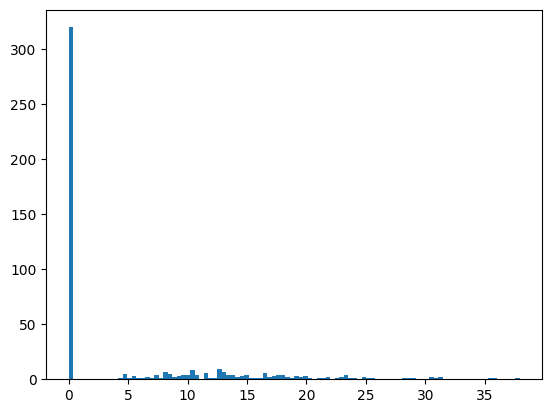

In [130]:
plt.hist((cls_transitions * 2000).values.flatten(), bins=100);

### Renormalize to human genome

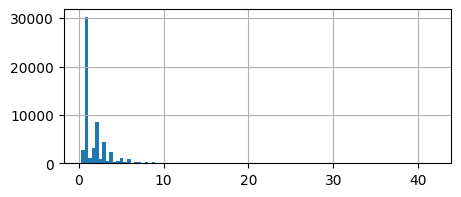

In [129]:
plt.figure(figsize=(5, 2))
species_spectra.Observed.hist(bins=100)
plt.show()

In [153]:
def read_human_triplet_counts():
    with open("../data/triplet_counts_GRCh37.json") as fin:
        _human_counts_raw = json.load(fin)
        _human_counts_raw = {x: _human_counts_raw[x] for x in possible_codons}
        human_counts = defaultdict(int)
        for triplet, n in _human_counts_raw.items():
            human_counts[triplet.upper()] += n
        human_counts = dict(human_counts)
        return human_counts


human_counts = read_human_triplet_counts()

In [145]:
# forvard and rev-comp triplets (pairs) freqs are almost equal
d = defaultdict(dict)
for triplet, n in human_counts.items():
    if triplet[1] in "CT":
        # print(triplet, n)
        d[triplet]["cosmic"] = n
    else:
        d[rev_comp(triplet)]["other"] = n

d = pd.DataFrame(d).T
d["diff"] = d.cosmic - d.other
d["diff%"] = d["diff"] / d['cosmic']
d

,other,cosmic,diff,diff%
TTT,52955787,53104035,148248,0.002792
GTT,27685307,27789456,104149,0.003748
CTT,39328248,39390888,62640,0.001590
ATT,42582891,42641599,58708,0.001377
ACA,37690444,37558475,-131969,-0.003514
ACC,22396794,22362749,-34045,-0.001522
ACG,5075138,5065207,-9931,-0.001961
ACT,32216082,32173783,-42299,-0.001315
TCT,41895792,41940160,44368,0.001058
GCT,27570880,27581893,11013,0.000399


So, need to use triplets with C & T in 2nd position

In [148]:
multiplier = cls_transitions.index.to_series().apply(lambda x: x[0] + x[2] + x[-1]).map(human_counts)
multiplier

MutationType
A[C>A]A    37558475
A[C>A]C    22362749
A[C>A]G     5065207
A[C>A]T    32173783
A[C>G]A    37558475
             ...   
T[T>C]T    53104035
T[T>G]A    36702017
T[T>G]C    37682795
T[T>G]G    35419535
T[T>G]T    53104035
Name: MutationType, Length: 96, dtype: int64

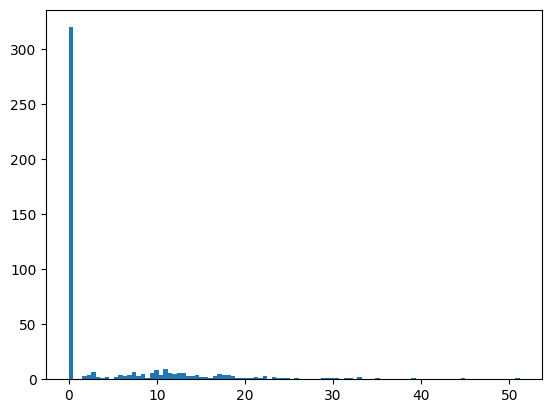

In [149]:
rescaled = (cls_transitions.T * multiplier).T / 1.5e4
plt.hist(rescaled.values.flatten(), bins=100);

In [150]:
rescaled.astype(int).to_csv("../data/decomp/sample2.txt", sep="\t")

### Many variants:

- **low ts** only
- **low ts** + mean tv [(h + l) / 2]
- **high ts** only
- **high ts** + mean tv [(h + l) / 2]
- **high - low** ts only
- **high - low** ts + mean tv [(h + l) / 2]

In [154]:
def save_wide_cls_spectra(df: pd.DataFrame, filename=None, scale_coef=6.6e-5):
    assert df.shape[1] == 96
    df.columns.name = "MutationType"
    multiplier = df.columns.to_series().apply(lambda x: x[0] + x[2] + x[-1]).map(human_counts)
    rescaled = (df * multiplier * scale_coef).T
    rescaled = rescaled.round().astype(int)
    if filename is not None:
        rescaled.sort_index().to_csv(filename, sep="\t")
    return rescaled

In [158]:
species_spectra_wide = complete_sbs_columns(
    species_spectra.groupby(["Class", "Species", "Mut"]).MutSpec.sum().unstack(), 192)
cls_spectra_wide = species_spectra_wide.mean(level=0)
cls_spectra_wide.head()

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000066,0.001479,0.000500,0.0,0.000865,0.002439,0.000998,0.0,0.000387,0.000729,...,0.001011,0.0,0.001081,0.001138,0.002074,0.0,0.000458,0.000397,0.000828,0.0
Amphibia,0.000000,0.000273,0.000506,0.0,0.001441,0.004229,0.001683,0.0,0.000102,0.000000,...,0.000734,0.0,0.000593,0.000470,0.001442,0.0,0.000355,0.000000,0.001295,0.0
Aves,0.000000,0.000000,0.000051,0.0,0.000048,0.000000,0.000088,0.0,0.000000,0.001011,...,0.000374,0.0,0.000633,0.001844,0.001183,0.0,0.000364,0.000000,0.000183,0.0
Lepidosauria,0.000023,0.001169,0.000357,0.0,0.001099,0.002600,0.001345,0.0,0.000801,0.000801,...,0.000593,0.0,0.000765,0.000169,0.001713,0.0,0.000393,0.000233,0.000728,0.0
Mammalia,0.000000,0.000783,0.000064,0.0,0.001615,0.001756,0.000464,0.0,0.000140,0.000724,...,0.000524,0.0,0.000615,0.000608,0.000894,0.0,0.000375,0.000394,0.000538,0.0


**Only Ts's**

In [162]:
sbs_low_ts = ["G>A", "T>C"]
low_ts_only = collapse_sbs192(complete_sbs_columns(
    cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_low_ts]], 192), 96)
save_wide_cls_spectra(low_ts_only, "../data/decomp/low_ts_only.txt")
low_ts_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
sbs_high_ts = ["C>T", "A>G"]
high_ts_only = collapse_sbs192(complete_sbs_columns(
    cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_high_ts]], 192), 96)
high_ts_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
high_minus_low_ts_only = high_ts_only - low_ts_only
high_minus_low_ts_only[high_minus_low_ts_only < 0] = 0
high_minus_low_ts_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amphibia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lepidosauria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mammalia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Ts's + Tv's**

In [165]:
sbs_tv = ['A>C', 'A>T', 'C>A', 'C>G', 'G>C', 'G>T', 'T>A', 'T>G']
tv_only = collapse_sbs192(complete_sbs_columns(
    cls_spectra_wide[[x for x in possible_sbs192 if x[2:5] in sbs_tv]], 192), 96) / 2
tv_only

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000065,0.000459,0.000252,0.0,0.001387,0.000966,0.000736,0.000556,0.001555,0.000571,...,0.001004,0.000250,0.001659,0.000933,0.002256,0.000740,0.000406,0.000392,0.000847,0.000033
Amphibia,0.000000,0.000113,0.000000,0.0,0.001436,0.003285,0.001856,0.001142,0.000308,0.000556,...,0.001209,0.000253,0.000562,0.000235,0.002835,0.000136,0.000177,0.000051,0.001368,0.000000
Aves,0.000000,0.000000,0.000000,0.0,0.000866,0.000649,0.001015,0.000775,0.000272,0.000231,...,0.000231,0.000026,0.000456,0.001427,0.000591,0.000000,0.000738,0.000000,0.000115,0.000000
Lepidosauria,0.000008,0.001191,0.000077,0.0,0.003666,0.001244,0.002003,0.001190,0.001344,0.001543,...,0.000969,0.000178,0.000952,0.000485,0.002156,0.000584,0.000275,0.000517,0.000914,0.000011
Mammalia,0.000172,0.000525,0.000140,0.0,0.001253,0.001098,0.002255,0.000736,0.000743,0.001166,...,0.000494,0.000032,0.000575,0.000666,0.001325,0.000391,0.000280,0.000267,0.001076,0.000000


In [166]:
low_ts_with_tv = tv_only + low_ts_only
save_wide_cls_spectra(low_ts_with_tv, "../data/decomp/low_ts_with_tv.txt")
low_ts_with_tv

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000065,0.000459,0.000252,0.0,0.001387,0.000966,0.000736,0.000556,0.001555,0.000571,...,0.001004,0.000250,0.001659,0.000933,0.002256,0.000740,0.000406,0.000392,0.000847,0.000033
Amphibia,0.000000,0.000113,0.000000,0.0,0.001436,0.003285,0.001856,0.001142,0.000308,0.000556,...,0.001209,0.000253,0.000562,0.000235,0.002835,0.000136,0.000177,0.000051,0.001368,0.000000
Aves,0.000000,0.000000,0.000000,0.0,0.000866,0.000649,0.001015,0.000775,0.000272,0.000231,...,0.000231,0.000026,0.000456,0.001427,0.000591,0.000000,0.000738,0.000000,0.000115,0.000000
Lepidosauria,0.000008,0.001191,0.000077,0.0,0.003666,0.001244,0.002003,0.001190,0.001344,0.001543,...,0.000969,0.000178,0.000952,0.000485,0.002156,0.000584,0.000275,0.000517,0.000914,0.000011
Mammalia,0.000172,0.000525,0.000140,0.0,0.001253,0.001098,0.002255,0.000736,0.000743,0.001166,...,0.000494,0.000032,0.000575,0.000666,0.001325,0.000391,0.000280,0.000267,0.001076,0.000000


In [167]:
high_ts_with_tv = tv_only + high_ts_only
high_ts_with_tv

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000065,0.000459,0.000252,0.0,0.001387,0.000966,0.000736,0.000556,0.001555,0.000571,...,0.001004,0.000250,0.001659,0.000933,0.002256,0.000740,0.000406,0.000392,0.000847,0.000033
Amphibia,0.000000,0.000113,0.000000,0.0,0.001436,0.003285,0.001856,0.001142,0.000308,0.000556,...,0.001209,0.000253,0.000562,0.000235,0.002835,0.000136,0.000177,0.000051,0.001368,0.000000
Aves,0.000000,0.000000,0.000000,0.0,0.000866,0.000649,0.001015,0.000775,0.000272,0.000231,...,0.000231,0.000026,0.000456,0.001427,0.000591,0.000000,0.000738,0.000000,0.000115,0.000000
Lepidosauria,0.000008,0.001191,0.000077,0.0,0.003666,0.001244,0.002003,0.001190,0.001344,0.001543,...,0.000969,0.000178,0.000952,0.000485,0.002156,0.000584,0.000275,0.000517,0.000914,0.000011
Mammalia,0.000172,0.000525,0.000140,0.0,0.001253,0.001098,0.002255,0.000736,0.000743,0.001166,...,0.000494,0.000032,0.000575,0.000666,0.001325,0.000391,0.000280,0.000267,0.001076,0.000000


In [168]:
high_minus_low_ts_with_tv = tv_only + high_minus_low_ts_only
high_minus_low_ts_with_tv

Mut,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Class,,,,,,,,,,,,,,,,,,,,,
Actinopteri,0.000065,0.000459,0.000252,0.0,0.001387,0.000966,0.000736,0.000556,0.001555,0.000571,...,0.001004,0.000250,0.001659,0.000933,0.002256,0.000740,0.000406,0.000392,0.000847,0.000033
Amphibia,0.000000,0.000113,0.000000,0.0,0.001436,0.003285,0.001856,0.001142,0.000308,0.000556,...,0.001209,0.000253,0.000562,0.000235,0.002835,0.000136,0.000177,0.000051,0.001368,0.000000
Aves,0.000000,0.000000,0.000000,0.0,0.000866,0.000649,0.001015,0.000775,0.000272,0.000231,...,0.000231,0.000026,0.000456,0.001427,0.000591,0.000000,0.000738,0.000000,0.000115,0.000000
Lepidosauria,0.000008,0.001191,0.000077,0.0,0.003666,0.001244,0.002003,0.001190,0.001344,0.001543,...,0.000969,0.000178,0.000952,0.000485,0.002156,0.000584,0.000275,0.000517,0.000914,0.000011
Mammalia,0.000172,0.000525,0.000140,0.0,0.001253,0.001098,0.002255,0.000736,0.000743,0.001166,...,0.000494,0.000032,0.000575,0.000666,0.001325,0.000391,0.000280,0.000267,0.001076,0.000000


Concatenate pairwise all 6 variants

In [170]:
d = []
for x, _lbl in zip(
    [low_ts_only, low_ts_with_tv],
    ["Ts only", "Ts & Tv"]
    ):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
total_samples = pd.concat(d)
save_wide_cls_spectra( 
    total_samples, 
    "../data/decomp/SigProfilerAssignment/input/low_Ts_samples.txt"
)


d = []
for x, _lbl in zip(
    [high_ts_only, high_ts_with_tv],
    ["Ts only", "Ts & Tv"]
    ):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
total_samples = pd.concat(d)
save_wide_cls_spectra( 
    total_samples, 
    "../data/decomp/SigProfilerAssignment/input/high_Ts_samples.txt"
)


d = []
for x, _lbl in zip(
    [high_minus_low_ts_only, high_minus_low_ts_with_tv],
    ["Ts only", "Ts & Tv"]
    ):
    x = x.copy()
    x.index = [y + f"__{_lbl}" for y in x.index]
    d.append(x)
total_samples = pd.concat(d)
save_wide_cls_spectra( 
    total_samples, 
    "../data/decomp/SigProfilerAssignment/input/high_minus_low_Ts_samples.txt"
)

,Actinopteri__Ts only,Amphibia__Ts only,Aves__Ts only,Lepidosauria__Ts only,Mammalia__Ts only,Actinopteri__Ts & Tv,Amphibia__Ts & Tv,Aves__Ts & Tv,Lepidosauria__Ts & Tv,Mammalia__Ts & Tv
MutationType,,,,,,,,,,
A[C>A]A,0,0,0,0,0,0,0,0,0,0
A[C>A]C,0,0,0,0,0,1,0,0,2,1
A[C>A]G,0,0,0,0,0,0,0,0,0,0
A[C>A]T,0,0,0,0,0,0,0,0,0,0
C[C>A]A,0,0,0,0,0,3,3,2,8,3
...,...,...,...,...,...,...,...,...,...,...
G[T>G]T,0,0,0,0,0,1,0,0,1,1
T[T>G]A,0,0,0,0,0,1,0,2,1,1
T[T>G]C,0,0,0,0,0,1,0,0,1,1


In [171]:
save_wide_cls_spectra(collapse_sbs192(cls_spectra_wide, 96), 
                      "../data/decomp/simple_96_saples.txt")

Class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
MutationType,,,,,
A[C>A]A,0,0,0,0,1
A[C>A]C,1,0,0,4,2
A[C>A]G,0,0,0,0,0
A[C>A]T,0,0,0,0,0
C[C>A]A,6,7,4,17,6
...,...,...,...,...,...
G[T>G]T,3,1,0,2,1
T[T>G]A,2,1,4,1,1
T[T>G]C,2,0,0,3,1


# Results

## Test on low_ts_only

### Round 1. Simplified emulation of human nuclear mutations without renormalization

In [68]:
samples = "../data/decomp/sample1.txt"
output = "../data/decomp/try1/"

exclude_signature_subgroups = [
    'Immunosuppressants_signatures',
    'Treatment_signatures',
    'AA_signatures',
    'Colibactin_signatures',
    'Artifact_signatures',
    'Lymphoid_signatures',
]

Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                   collapse_to_SBS96=True, cosmic_version=3.3, exome=False,
                   signature_database=None,
                   exclude_signature_subgroups=exclude_signature_subgroups, 
                   export_probabilities=True,
                   export_probabilities_per_mutation=False, make_plots=True,
                   sample_reconstruction_plots=False, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS22 SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 5/5 [100%] in 0.3s (14.70/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


Another rough result (need to carefully setup SigProfiller before execution on mito-spectra):

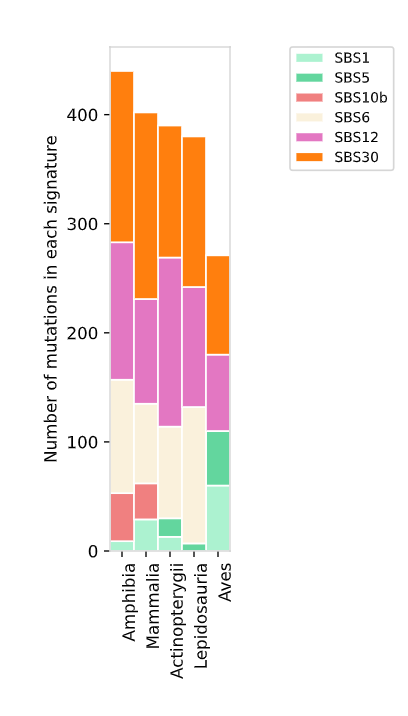

In [77]:
print("Main signatures:")
for x in ["SBS30", "SBS12", "SBS6"]:
    print(f"  {x} - {sbs2effect.get(x, 'UNK')}")

Main signatures:
  SBS30 - BER_deficiency
  SBS12 - UNK
  SBS6 - MMR_deficiency


In [70]:
pd.read_csv("../data/decomp/try1/Assignment_Solution/Solution_Stats/Assignment_Solution_Samples_Stats.txt", sep='\t')

,Sample Names,Total Mutations,Cosine Similarity,L1 Norm,L1_Norm_%,L2 Norm,L2_Norm_%,KL Divergence,Correlation
0,Actinopterygii,390,0.913,165.266,42.376%,30.409,40.855%,0.18604,0.875
1,Amphibia,440,0.951,147.398,33.5%,27.526,30.957%,0.15007,0.935
2,Aves,271,0.908,139.931,51.635%,23.422,41.925%,0.26717,0.876
3,Lepidosauria,380,0.918,170.415,44.846%,30.606,39.691%,0.21004,0.889
4,Mammalia,402,0.962,122.833,30.555%,22.413,27.288%,0.14062,0.949


### Round 2. Emulation of human nuclear mutations WITH renormalization

In [12]:
from SigProfilerAssignment import Analyzer as Analyze

samples = "../data/decomp/sample2.txt"
output = "../data/decomp/try2/"

exclude_signature_subgroups = [
    'Immunosuppressants_signatures',
    'Treatment_signatures',
    'AA_signatures',
    'Colibactin_signatures',
    'Artifact_signatures',
    'Lymphoid_signatures',
]

Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                   cosmic_version=3.3, exome=False,
                   nnls_remove_penalty=0.01, nnls_add_penalty = 0.01,
                   exclude_signature_subgroups=exclude_signature_subgroups, 
                   export_probabilities=True, make_plots=True,
                   sample_reconstruction_plots=False, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS22 SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 5/5 [100%] in 0.7s (7.63/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


Another rough result (need to carefully setup SigProfiller before execution on mito-spectra):

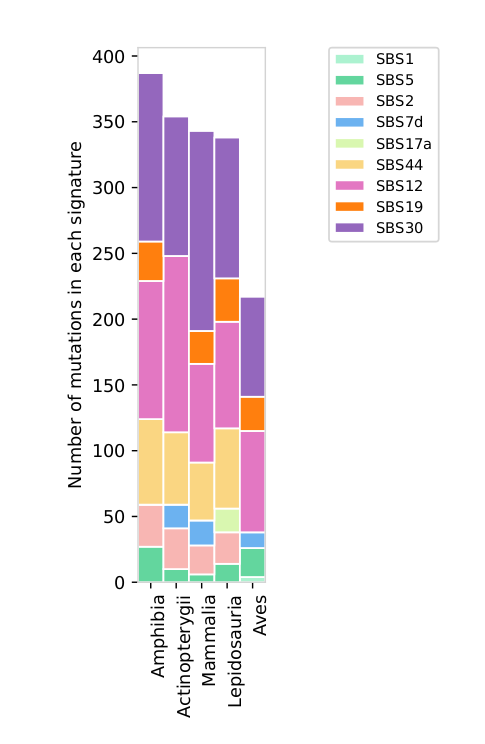

In [14]:
print("Main signatures:")
for x in ["SBS30", "SBS19", "SBS12", "SBS44", "SBS5"]:
    print(f"  {x} - {sbs2effect.get(x, 'UNK')}")

Main signatures:
  SBS30 - BER_deficiency
  SBS19 - UNK
  SBS12 - UNK
  SBS44 - MMR_deficiency
  SBS5 - UNK_clock_like


In [13]:
import pandas as pd
pd.read_csv("../data/decomp/try2/Assignment_Solution/Solution_Stats/Assignment_Solution_Samples_Stats.txt", sep='\t')

,Sample Names,Total Mutations,Cosine Similarity,L1 Norm,L1_Norm_%,L2 Norm,L2_Norm_%,KL Divergence,Correlation
0,Actinopterygii,354,0.938,150.351,42.472%,25.596,35.272%,0.19825,0.918
1,Amphibia,387,0.934,169.726,43.857%,31.023,36.743%,0.21563,0.917
2,Aves,217,0.922,91.244,42.048%,17.710,39.414%,0.22095,0.898
3,Lepidosauria,338,0.914,165.618,48.999%,30.013,41.164%,0.26649,0.889
4,Mammalia,343,0.959,122.433,35.695%,21.870,29.067%,0.16890,0.948


## Round 3: Total variants

### Run SigProfilerAssignment

In [217]:
from SigProfilerAssignment import Analyzer as Analyze

samples_pattern = "../data/decomp/SigProfilerAssignment/input/{}_samples.txt"
output_pattern = "../data/decomp/SigProfilerAssignment/output/{}/"

exclude_signature_subgroups = [
    'Artifact_signatures',
    'Immunosuppressants_signatures',
    'Treatment_signatures',
    'Lymphoid_signatures',
    'Colibactin_signatures',
    'AA_signatures',
]

for label in ["low_Ts", "high_Ts", "high_minus_low_Ts"]:
    samples = samples_pattern.format(label)
    output  = output_pattern.format(label)
    Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
                    cosmic_version=3.3, exome=False,
                    nnls_remove_penalty=0.01, nnls_add_penalty = 0.02,
                    exclude_signature_subgroups=exclude_signature_subgroups, 
                    export_probabilities=False, make_plots=True,
                    sample_reconstruction_plots=False, verbose=False)

The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS99 SBS22 SBS22a SBS22b SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 


|████████████████████████████████████████| 10/10 [100%] in 1.4s (7.09/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS99 SBS22 SBS22a SBS22b SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 10/10 [100%] in 3.0s (3.32/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
The following signatures are excluded: SBS32 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS99 SBS22 SBS22a SBS22b SBS88 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95 SBS9 SBS84 SBS85
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 10/10 [100%] in 1.7s (5

In [218]:
# make Solution_Stats with assignment quality
d = pd.concat([pd.read_csv(f"../data/decomp/SigProfilerAssignment/output/{label}/"
        "Assignment_Solution/Solution_Stats/Assignment_Solution_Samples_Stats.txt", sep='\t')\
            .assign(Run=label).set_index(['Run', 'Sample Names']) \
            for label in ["low_Ts", "high_Ts", "high_minus_low_Ts"]])
d.to_csv('../data/decomp/SigProfilerAssignment/output/Solution_Stats.txt', sep='\t')
d.head(2)

Total Mutations  Cosine Similarity  L1 Norm  \
Run    Sample Names                                                        
low_Ts Actinopteri__Ts only              496              0.938  202.460   
       Amphibia__Ts only                 507              0.916  233.596   

                            L1_Norm_%  L2 Norm L2_Norm_%  KL Divergence  \
Run    Sample Names                                                       
low_Ts Actinopteri__Ts only   40.819%   34.667   34.955%        0.17688   
       Amphibia__Ts only      46.074%   43.321   40.611%        0.22380   

                             Correlation  
Run    Sample Names                       
low_Ts Actinopteri__Ts only        0.915  
       Amphibia__Ts only           0.889

### Make beautiful images and add them to single panel
in the scpipt [plotActivity.py](./plotActivity.py)

In [14]:
import pandas as pd

# merge tables to 'total' one
data = []
index_odr = [
 'Actinopteri__Ts only',
 'Amphibia__Ts only',
 'Aves__Ts only',
 'Lepidosauria__Ts only',
 'Mammalia__Ts only',
 'Actinopteri__Ts & Tv',
 'Amphibia__Ts & Tv',
 'Aves__Ts & Tv',
 'Lepidosauria__Ts & Tv',
 'Mammalia__Ts & Tv',
 ]

for label in ["high_Ts", "low_Ts", "high_minus_low_Ts"]:
    d = pd.read_csv(f'../data/decomp/SigProfilerAssignment/output/{label}/'
                'Assignment_Solution/Activities/Assignment_Solution_Activities.txt', 
                sep='\t', index_col=0).loc[index_odr]
    
    if label == 'low_Ts':
        label = 'low-'
    elif label == 'high_Ts':
        label = 'high-'
    elif label == 'high_minus_low_Ts':
        label = 'diff-'
    
    d.index = label + d.index.str.replace(' only', '')
    data.append(d)

df_full = pd.concat(data)
df_ts_only = df_full.loc[~df_full.index.str.contains('Tv')]
df_ts_only.index = df_ts_only.index.str.replace('__Ts', '')


path_to_total_acivities = '../data/decomp/SigProfilerAssignment/output/Assignment_Solution_Activities.txt'
df_full.to_csv(path_to_total_acivities, sep='\t')
df_ts_only.to_csv(path_to_total_acivities.replace('.txt', '_Ts.txt'), sep='\t')
df_full.head()

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS39,SBS40,SBS41,SBS42,SBS44,SBS89,SBS91,SBS92,SBS93,SBS94
Samples,,,,,,,,,,,,,,,,,,,,,
high-Actinopteri__Ts,3,0,0,0,208,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
high-Amphibia__Ts,0,57,0,0,102,0,0,0,0,0,...,0,0,0,0,193,0,0,0,0,0
high-Aves__Ts,0,0,0,0,342,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
high-Lepidosauria__Ts,3,0,0,0,203,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
high-Mammalia__Ts,0,0,0,0,189,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# total
from plotActivity import plotActivity

custom_colors = ['lightgray', '#63d69e', 'lightgray', '#fcde97', '#fcde97', 
                 'tab:pink', 'lightgray', 'lightgray', 'tab:purple']
outpath = "../data/decomp/SigProfilerAssignment/output/total.pdf"
plotActivity(
    path_to_total_acivities, outpath, 
    bin_size=30, 
    # custom_colors=custom_colors,
    delimiter_step=10, delimiter_size=2,
    # rename=True,
)

['#acf2d0', '#63d69e', '#f8b6b3', '#fcde97', '#fad682', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive']


In [21]:
# only Ts
from plotActivity import plotActivity

custom_colors = ['#acf2d0', '#63d69e', '#f8b6b3', '#fcde97', '#fad682', 
                 'tab:pink', 'tab:olive', 'tab:orange', 'tab:purple']
outpath = "../data/decomp/SigProfilerAssignment/output/only_Ts.pdf"
plotActivity(
    path_to_total_acivities.replace('.txt', '_Ts.txt'), 
    outpath, 
    bin_size=50, 
    custom_colors=custom_colors,
    delimiter_step=5, delimiter_size=2,
    rename=True, figure_width=4,
)

Colors replaced
['#acf2d0', '#63d69e', '#f8b6b3', '#fcde97', '#fad682', 'tab:pink', 'tab:olive', 'tab:orange', 'tab:purple']


### Legacy for testing

In [ ]:
# from SigProfilerAssignment import Analyzer as Analyze

# samples = "../data/decomp/low_ts_only.txt"
# output = "../data/decomp/low_ts_only/"

# Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
#                 cosmic_version=3.3, exome=False,
#                 nnls_remove_penalty=0.01, nnls_add_penalty = 0.02,
#                 exclude_signature_subgroups=exclude_signature_subgroups, 
#                 export_probabilities=False, make_plots=True,
#                 sample_reconstruction_plots=True, verbose=False)

In [ ]:
# from SigProfilerAssignment import Analyzer as Analyze

# samples = "../data/decomp/low_ts_with_tv.txt"
# output = "../data/decomp/low_ts_with_tv/"

# Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
#                 cosmic_version=3.3, exome=False,
#                 nnls_remove_penalty=0.01, nnls_add_penalty = 0.02,
#                 exclude_signature_subgroups=exclude_signature_subgroups, 
#                 export_probabilities=False, make_plots=True,
#                 sample_reconstruction_plots=True, verbose=False)

In [ ]:
# from SigProfilerAssignment import Analyzer as Analyze

# samples = "../data/decomp/simple_96_saples.txt"
# output = "../data/decomp/simple_96_saples/"

# Analyze.cosmic_fit(samples, output, input_type="matrix", context_type="96",
#                 cosmic_version=3.3, exome=False,
#                 nnls_remove_penalty=0.01, nnls_add_penalty = 0.02,
#                 exclude_signature_subgroups=exclude_signature_subgroups, 
#                 export_probabilities=False, make_plots=True,
#                 sample_reconstruction_plots=True, verbose=False)

## Priors for mSigAct

In [2]:
import pandas as pd
df = pd.read_csv('../data/decomp/SigProfilerAssignment/output/Assignment_Solution_Activities.txt', sep='\t', index_col=0)
df.head()

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS39,SBS40,SBS41,SBS42,SBS44,SBS89,SBS91,SBS92,SBS93,SBS94
Samples,,,,,,,,,,,,,,,,,,,,,
low-Actinopteri__Ts,2,26,0,0,37,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
low-Actinopteri__Ts & Tv,0,29,0,0,171,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
low-Amphibia__Ts,2,34,0,0,71,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
low-Amphibia__Ts & Tv,0,37,0,0,194,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
low-Aves__Ts,6,0,0,0,28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
sbs_priors = df.sum(axis=0)
sbs_priors = (sbs_priors[sbs_priors > 0] / sbs_priors.sum()).round(2)
sbs_priors = sbs_priors[sbs_priors >= 0.01] # frequent then 1%
sbs_priors.sort_values()

SBS2     0.01
SBS26    0.02
SBS19    0.03
SBS23    0.03
SBS44    0.03
SBS5     0.23
SBS12    0.31
SBS30    0.35
dtype: float64

In [ ]:
#legacy
sbs_priors = df.sum(axis=0)
sbs_priors = (sbs_priors[sbs_priors > 0] / sbs_priors.sum()).round(2)
sbs_priors = sbs_priors[sbs_priors >= 0.01] # frequent then 1%
sbs_priors.sort_values()

SBS2     0.01
SBS23    0.03
SBS44    0.06
SBS5     0.18
SBS30    0.33
SBS12    0.38
dtype: float64

## Plot btacked barplots for mSigAct

In [11]:
# total
import pandas as pd
from plotActivity import plotActivity

custom_colors = [
    '#acf2d0', '#63d69e', '#f8b6b3', '#c4abc4', '#f2aeae', '#d9f7b0', 
    '#faf1dc', '#fcebc2', '#fae4af', '#fae1a5', '#fcde97', '#fad682', 
    'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:brown', 
    'tab:red', 'tab:green', 'tab:cyan', 'deeppink', 'lightgray', 'blueviolet', 
    'chocolate', 'darkgreen', 'dodgerblue', 'gray', 'salmon']


inpath  = "../data/decomp/mSigAct/output/all_relatable_sbs_prop1_Activities.txt"
outpath = "../data/decomp/mSigAct/output/all_relatable_sbs_prop1_Activities.pdf"

df = pd.read_csv(inpath, sep='\t')
print(df.shape)
df['Set'] = df.Samples.apply(lambda x: x.split('_')[0])
df['WithTv'] = df.Samples.str.contains('Tv')
df['Samples'] = df['Samples'].str.replace('.only', '').str.replace('\.\.\.', ' & ')
df = df.sort_values(['Set', 'WithTv', 'Samples']).set_index('Set').loc[['high', 'low', 'diff']]
df = df.set_index('Samples').astype(int).drop('WithTv', 1)
# drop signatures with low fraction (< 0.5%)
df = df.loc[:, (df.T / df.sum(1)).T.mean() >= 0.005]
print(df.shape)
df.to_csv(inpath+'.sorted', sep='\t')

plotActivity(
    inpath+'.sorted', 
    outpath, 
    bin_size=30, 
    # custom_colors=custom_colors,
    delimiter_step=10, delimiter_size=3,
    # rename=True,
)

(30, 29)
(30, 13)
['#f8b6b3', '#c4abc4', '#faf1dc', '#fae1a5', '#fcde97', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:brown', 'tab:red', 'tab:green', 'tab:cyan']


/tmp/ipykernel_24810/477448024.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Samples'] = df['Samples'].str.replace('.only', '').str.replace('\.\.\.', ' & ')
/tmp/ipykernel_24810/477448024.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index('Samples').astype(int).drop('WithTv', 1)


In [23]:
# only Ts
import pandas as pd
from plotActivity import plotActivity

inpath  = "../data/decomp/mSigAct/output/all_relatable_sbs_prop1_Activities.txt"
outpath = "../data/decomp/mSigAct/output/all_relatable_sbs_prop1_Activities_Ts.pdf"

df = pd.read_csv(inpath, sep='\t')
print(df.shape)
df['Set'] = df.Samples.apply(lambda x: x.split('_')[0])
df['WithTv'] = df.Samples.str.contains('Tv')
df['Samples'] = df['Samples'].str.replace('__Ts.only', '').str.replace('_', '-')
df = df[~df['Samples'].str.contains('\.\.\.')]
df = df.sort_values(['Set', 'WithTv', 'Samples']).set_index('Set').loc[['high', 'low', 'diff']]
df = df.set_index('Samples').astype(int).drop('WithTv', 1)
# drop signatures with low fraction (< 0.5%)
df = df.loc[:, (df.T / df.sum(1)).T.mean() >= 0.005]
print(df.shape)
df.to_csv(inpath+'.sorted.ts', sep='\t')

plotActivity(
    inpath+'.sorted.ts', 
    outpath, 
    bin_size=50, 
    scale=True,
    # custom_colors=custom_colors,
    delimiter_step=5, delimiter_size=2,
    rename=True, figure_width=4,
)

(30, 29)
(15, 7)
['#f8b6b3', '#faf1dc', '#fae1a5', '#fcde97', 'tab:pink', 'tab:orange', 'tab:purple']


/tmp/ipykernel_24810/885822662.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Samples'] = df['Samples'].str.replace('__Ts.only', '').str.replace('_', '-')
/tmp/ipykernel_24810/885822662.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index('Samples').astype(int).drop('WithTv', 1)


### When using some priors

In [ ]:
from plotActivity import plotActivity

custom_colors = ['#63d69e', '#fad682', '#fad682', 'tab:purple', 
                 'tab:pink', 'tab:orange', 'lightgray']

inpath  = "../data/decomp/mSigAct/output/custom_prop_Activities.txt"
outpath = "../data/decomp/mSigAct/output/custom_prop_Activities.pdf"

df = pd.read_csv(inpath, sep='\t')
df['Set'] = df.Samples.apply(lambda x: x.split('_')[0])
df['Samples'] = df['Samples'].str.replace('.only', '').str.replace('\.\.\.', ' & ')
df = df.sort_values(['Set', 'Samples']).set_index('Set').loc[['high', 'low', 'diff']]
df = df.set_index('Samples', append=True).astype(int).reset_index(1)
df.to_csv(inpath+'.sorted', index=False, sep='\t')

plotActivity(
    inpath+'.sorted', 
    outpath, 
    bin_size=30, 
    # custom_colors=custom_colors,
    delimiter_step=10, delimiter_size=3,
    # rename=True,
)

['#63d69e', '#fcde97', '#fad682', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive']


In [ ]:
from plotActivity import plotActivity

custom_colors = ['#63d69e', '#fad682', '#fad682', 'tab:purple', 
                 'tab:pink', 'tab:orange', 'lightgray']

inpath  = "../data/decomp/mSigAct/output/custom_from1_Activities.txt"
outpath = "../data/decomp/mSigAct/output/custom_from1_Activities.pdf"

df = pd.read_csv(inpath, sep='\t')
df['Set'] = df.Samples.apply(lambda x: x.split('_')[0])
df['Samples'] = df['Samples'].str.replace('.only', '').str.replace('\.\.\.', ' & ')
df = df.sort_values(['Set', 'Samples']).set_index('Set').loc[['high', 'low', 'diff']]
df = df.set_index('Samples', append=True).astype(int).reset_index(1)
df.to_csv(inpath+'.sorted', index=False, sep='\t')

plotActivity(
    inpath+'.sorted', 
    outpath, 
    bin_size=30, 
    # custom_colors=custom_colors,
    delimiter_step=10, delimiter_size=3,
    # rename=True,
)

['#f8b6b3', '#fae1a5', '#fcde97', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:brown']


## Check input spectra

In [4]:
low = pd.read_csv('../data/decomp/SigProfilerAssignment/input/low_Ts_samples.txt', sep='\t', index_col=0)
high = pd.read_csv('../data/decomp/SigProfilerAssignment/input/high_Ts_samples.txt', sep='\t', index_col=0)
hml = pd.read_csv('../data/decomp/SigProfilerAssignment/input/high_minus_low_Ts_samples.txt', sep='\t', index_col=0)

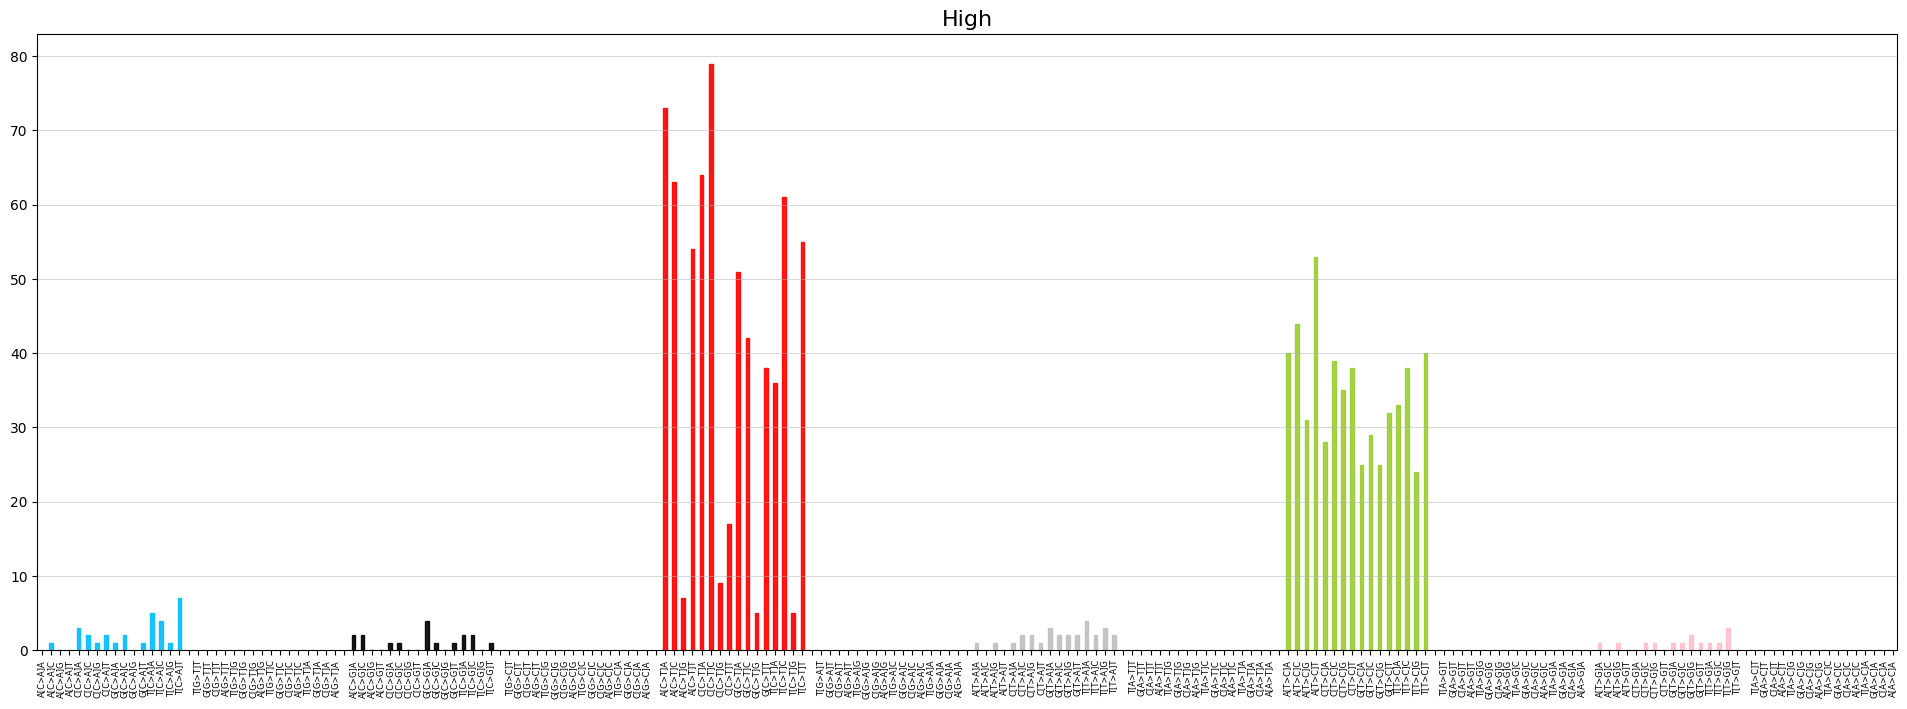

In [10]:
x = high['Mammalia__Ts & Tv'].rename('MutSpec')
x.index.name = 'Mut'
x = x.reset_index()
plot_mutspec192(x, title='High');

# Legacy (BE)

## C>T (light) similarity to COSMIC
1. cosine similarity with ALL cosmic signatures for 16 bins of GH>AH == CL>TL. Of course we have to compare it with C>T in cosmic, but before we need to reverse complement all 16 GH>AH.

In [ ]:
cls_spectra[cls_spectra.sbs12l == "C>T"].head()

,Class,sbs192h,MutSpec,sbs12h,sbs12l,sbs192l
24,Actinopterygii,A[G>A]A,0.006024,G>A,C>T,T[C>T]T
25,Actinopterygii,A[G>A]C,0.006952,G>A,C>T,G[C>T]T
26,Actinopterygii,A[G>A]G,0.003830,G>A,C>T,C[C>T]T
27,Actinopterygii,A[G>A]T,0.005455,G>A,C>T,A[C>T]T
72,Actinopterygii,C[G>A]A,0.009724,G>A,C>T,T[C>T]G


In [ ]:
data = []
for cls_name, gr in cls_spectra[cls_spectra.sbs12l == "C>T"].groupby("Class"):
    cosm_subset = cosmic96.loc[gr.sbs192l]
    for col in cosm_subset.columns:
        cos_dist = spatial.distance.cosine(cosm_subset[col], gr.MutSpec)
        data.append({
            "Class": cls_name,
            "COSMIC": col,
            "CosSim": 1 - cos_dist,
        })

similarities_ct_light = pd.DataFrame(data).pivot("Class", "COSMIC", "CosSim").T\
    .sort_values(['Mammalia', 'Aves','Actinopterygii', 'Amphibia', 'Lepidosauria'], ascending=False)

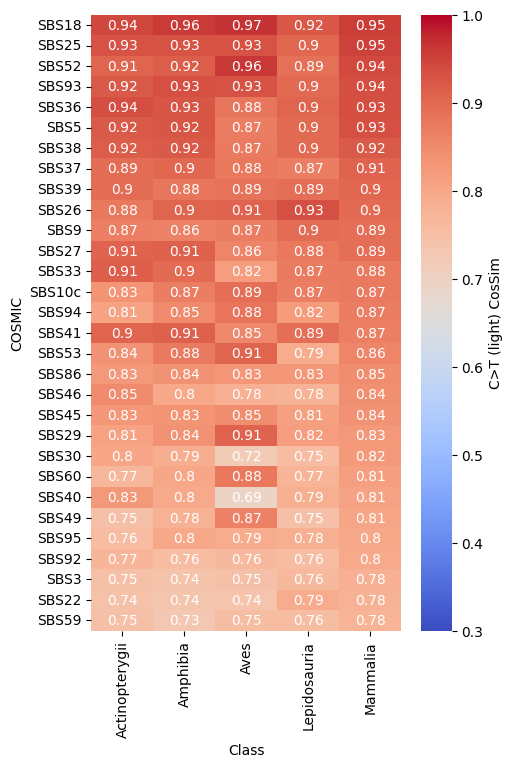

In [ ]:
plt.figure(figsize=(5, 8))
sns.heatmap(similarities_ct_light.head(30), annot=True, vmax=1, vmin=0.3, cmap="coolwarm", cbar_kws={"label": "C>T (light) CosSim"}, annot_kws={"color":"w"})
plt.show()

In [ ]:
similarities_ct_light["Effect"] = similarities_ct_light.index.map(sbs2effect)

In [ ]:
print(similarities_ct_light.round(2).head(20))

Class   Actinopterygii  Amphibia  Aves  Lepidosauria  Mammalia          Effect
COSMIC                                                                        
SBS18             0.94      0.96  0.97          0.92      0.95             ROS
SBS25             0.93      0.93  0.93          0.90      0.95       Treatment
SBS52             0.91      0.92  0.96          0.89      0.94        Artifact
SBS93             0.92      0.93  0.93          0.90      0.94             NaN
SBS36             0.94      0.93  0.88          0.90      0.93  BER_deficiency
SBS5              0.92      0.92  0.87          0.90      0.93             NaN
SBS38             0.92      0.92  0.87          0.90      0.92              UV
SBS37             0.89      0.90  0.88          0.87      0.91             NaN
SBS39             0.90      0.88  0.89          0.89      0.90             NaN
SBS26             0.88      0.90  0.91          0.93      0.90  MMR_deficiency
SBS9              0.87      0.86  0.87          0.90

## H - L
we want to get cosine similarity for all single-strand specific mutations (asymmetric ones), which we can get as heavy chain mutations minus light
strand mutations (we subtract reverse complement equivalent motivs, for example CCC>CTC on heavy strand - GGG>GAG on light strand). Finally we will get 96 numbers (minus some NA) which is good to have in terms of COSMIC (6 base substitution).
<!-- ```
Gh>Th - Gl>Tl (Ch>Ah)
Ch>Gh - Cl>Gl (Gh>Ch)
Ch>Th - Cl>Tl (Gh>Ah)
Ah>Th - Al>Tl (Th>Ah)
Ah>Gh - Al>Gl (Th>Ch)
Th>Gh - Tl>Gl (Ah>Ch)
``` -->

In [ ]:
# sbs6_main = ["G>T", "C>G", "C>T", "A>T", "A>G", "T>G"]
sbs6_main = cosmic.index.str.slice(2,5).unique().values
sbs6_main

array(['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G'], dtype=object)

In [ ]:
cls_spectra_heavy = cls_spectra[cls_spectra.sbs12h.isin(sbs6_main)].rename(columns={"sbs192h": "sbs96", "sbs12h": "sbs6"}).drop(["sbs192l", "sbs12l"], axis=1)
cls_spectra_light = cls_spectra[cls_spectra.sbs12l.isin(sbs6_main)].rename(columns={"sbs192l": "sbs96", "sbs12l": "sbs6"}).drop(["sbs192h", "sbs12h"], axis=1)

In [ ]:
cls_spectra96 = cls_spectra_heavy.merge(cls_spectra_light.drop("sbs6", axis=1), on=["Class", "sbs96"], suffixes=["_h", "_l"])
cls_spectra96["Diff"] = cls_spectra96.MutSpec_h - cls_spectra96.MutSpec_l
cls_spectra96.head()

,Class,sbs96,MutSpec_h,sbs6,MutSpec_l,Diff
0,Actinopterygii,A[C>A]A,0.000786,C>A,0.0,0.000786
1,Actinopterygii,A[C>A]C,0.001114,C>A,0.0,0.001114
2,Actinopterygii,A[C>A]G,0.001247,C>A,0.0,0.001247
3,Actinopterygii,A[C>A]T,0.000000,C>A,0.0,0.000000
4,Actinopterygii,A[C>G]A,0.003199,C>G,0.0,0.003199


Some values are **negative** bacause values on light strand for some substitutions ware greater

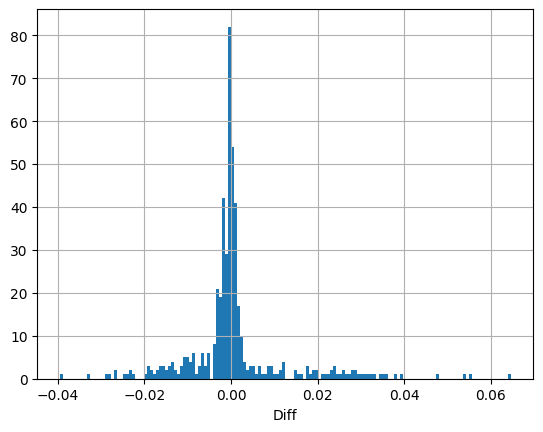

In [ ]:
cls_spectra96.Diff.hist(bins=150)
plt.xlabel("Diff");

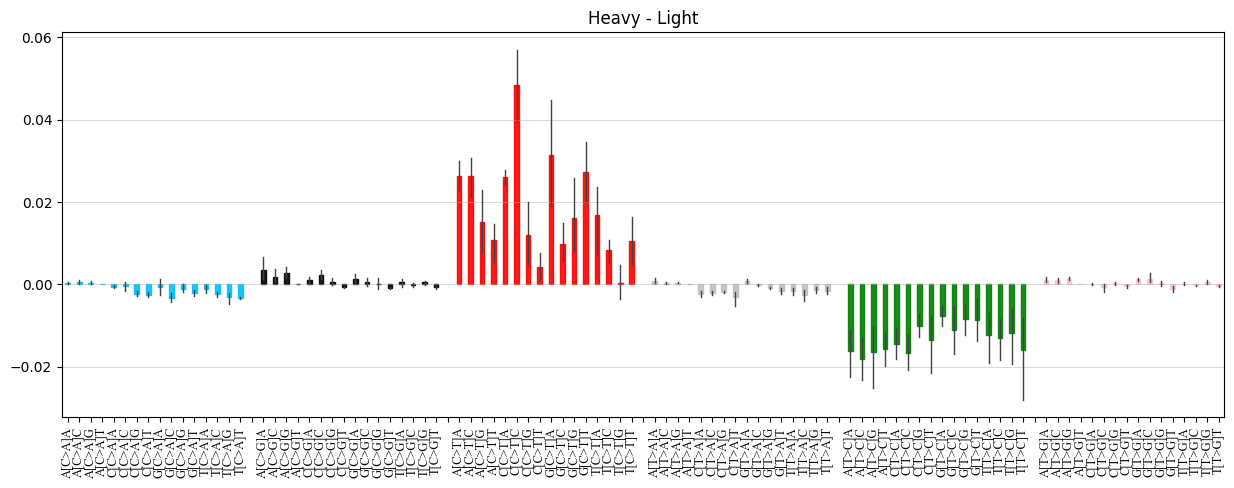

In [ ]:
plot_mutspec96(cls_spectra96.rename(columns={"sbs96": "Mut"}), "Diff", "Heavy - Light")

In [ ]:
data2 = []
for cls_name, gr in cls_spectra96.groupby("Class"):
    cosm_subset = cosmic96.loc[gr.sbs96]
    for col in cosm_subset.columns:
        cos_dist = spatial.distance.cosine(cosm_subset[col], gr.MutSpec)
        data2.append({
            "Class": cls_name,
            "COSMIC": col,
            "CosSim": 1 - cos_dist,
        })

similarities_diff_light = pd.DataFrame(data2).pivot("Class", "COSMIC", "CosSim").T\
    .sort_values(['Mammalia', 'Aves','Actinopterygii', 'Amphibia', 'Lepidosauria'], ascending=False)

In [ ]:
gr

,Class,sbs96,MutSpec_h,sbs6,MutSpec_l,Diff
0,Actinopterygii,A[A>G]A,0.010700,A>G,0.004133,0.006568
1,Actinopterygii,A[A>G]C,0.014734,A>G,0.007639,0.007096
2,Actinopterygii,A[A>G]G,0.011472,A>G,0.003063,0.008408
3,Actinopterygii,A[A>G]T,0.014797,A>G,0.006446,0.008351
4,Actinopterygii,A[A>T]A,0.001568,A>T,0.000000,0.001568
...,...,...,...,...,...,...
91,Actinopterygii,T[G>T]T,0.000000,G>T,0.000786,-0.000786
92,Actinopterygii,T[T>G]A,0.000537,T>G,0.000527,0.000010
93,Actinopterygii,T[T>G]C,0.000333,T>G,0.000569,-0.000236
94,Actinopterygii,T[T>G]G,0.001069,T>G,0.000747,0.000321


In [ ]:
similarities_diff_light.head(10)

In [ ]:
plt.figure(figsize=(5, 8))
sns.heatmap(similarities_diff_light.head(30), annot=True, vmax=1, vmin=0.3, cmap="coolwarm", cbar_kws={"label": "C>T (light) CosSim"}, annot_kws={"color":"w"})
plt.show()

# Make SuplFile2 with mutspec of all verte3brate classes add. whole mutspec for vertebrates 

### Download mutspec of vertebrates, SBS cosmic data and cancer mutspec 


In [68]:
mut_vert = pd.read_csv('../data/MutSpecVertebratescytb.csv')
cosm_sbs = pd.read_table('../data/external/COSMIC_v3.3.1_SBS_GRCh37.txt')
canc_df = pd.read_csv('../data/external/cancer_mutspec.csv')


In [69]:
canc_df = canc_df[['Mut','MutSpec_ExDloop']]
canc_df = canc_df.rename(columns={"MutSpec_ExDloop":"Cancers"})
canc_df.head()

,Mut,Cancers
0,A[A>C]A,0.000000
1,A[A>C]C,0.000783
2,A[A>C]G,0.000000
3,A[A>C]T,0.000084
4,A[A>G]A,0.008273


### Look at cosmic and mutspec data


In [70]:
cosm_sbs.head()

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS86,SBS87,SBS88,SBS89,SBS90,SBS91,SBS92,SBS93,SBS94,SBS95
0,A[C>A]A,0.000886,5.800168e-07,0.020808,0.042196,0.011998,0.000425,0.000067,0.002329,0.004830,...,0.002954,0.008973,1.000000e-18,0.032169,0.002202,0.002945,0.011329,0.011573,0.015580,0.038408
1,A[C>A]C,0.002280,1.480043e-04,0.016507,0.033297,0.009438,0.000524,0.000179,0.000461,0.001150,...,0.003775,0.004573,1.000000e-18,0.017694,0.000708,0.052997,0.009745,0.008096,0.024746,0.017384
2,A[C>A]G,0.000177,5.230151e-05,0.001751,0.015599,0.001850,0.000052,0.000071,0.000186,0.000377,...,0.000385,0.006209,1.000000e-18,0.009671,0.000139,0.000204,0.004697,0.001761,0.001574,0.008360
3,A[C>A]T,0.001280,9.780282e-05,0.012205,0.029498,0.006609,0.000180,0.000248,0.000710,0.001960,...,0.003624,0.004957,1.731102e-03,0.020744,0.001755,0.000131,0.007758,0.008421,0.011076,0.023294
4,A[C>G]A,0.001860,2.230064e-16,0.019708,0.006889,0.010098,0.000471,0.000065,0.000009,0.001120,...,0.052516,0.007866,1.000000e-18,0.014817,0.000508,0.000243,0.003056,0.008857,0.007004,0.003617


In [71]:
mut_vert.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


### Calculate MutSpec for each class, vertebrates together and cancer

In [72]:
needed_classes = ["Actinopterygii","Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancers", 'Vertebrate']

supl_file1 = mut_vert.Mut.drop_duplicates()

for cls in needed_classes:
    if cls != 'Cancers':
        if cls != 'Vertebrate':
            mut_calc_cls = mut_vert[mut_vert.Class == cls]
        else:
            mut_calc_cls = mut_vert.copy()
        mut_calc_cls = mut_calc_cls.groupby(['Mut'])['RawMutSpec'].sum().reset_index()
        mut_calc_cls["RawMutSpecSum"] = mut_calc_cls.RawMutSpec.sum()
        mut_calc_cls['MutSpec'] = mut_calc_cls.RawMutSpec / mut_calc_cls.RawMutSpecSum
        mut_calc_cls = mut_calc_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
        mut_calc_cls = mut_calc_cls.rename(columns={'MutSpec':cls})
        supl_file1 = pd.merge(supl_file1, mut_calc_cls, on='Mut')
    else:
        supl_file1 = pd.merge(supl_file1, canc_df, on='Mut')

In [75]:
supl_file1 = supl_file1.rename(columns={'Mut':'Type'})
supl_file1.tail(5)

,Type,Actinopterygii,Amphibia,Lepidosauria,Mammalia,Aves,Cancers,Vertebrate
187,A[A>G]A,0.010700,0.010051,0.011129,0.016655,0.042268,0.008273,0.014522
188,T[A>C]A,0.000527,0.000218,0.000415,0.000219,0.000874,0.000000,0.000392
189,G[A>C]A,0.000569,0.000273,0.000558,0.000722,0.000583,0.000000,0.000625
190,C[A>C]A,0.000747,0.001582,0.000346,0.000584,0.000000,0.000745,0.000651
191,A[A>C]A,0.000873,0.000545,0.000099,0.000041,0.000000,0.000000,0.000424


In [74]:
supl_file1.to_csv('../ToPaper/SuplFiles/SupplementaryTable2.csv', index=False)

In [25]:
df = pd.read_csv("../ToPaper/SuplFiles/SupplementaryTable2.csv")
colname = "Freq[A>G], %"
df = df[df.Type.str.contains("A>G")].sum().rename(colname).reset_index().tail(7)
df[colname] = df[colname].astype(float).round(3) * 100
df.rename(columns={"index": "Class"}, inplace=True)
df

,Class,"Freq[A>G], %"
1,Actinopterygii,20.2
2,Amphibia,21.9
3,Lepidosauria,24.9
4,Mammalia,29.7
5,Aves,38.7
6,Cancers,20.7
7,Vertebrate,25.3
